In [34]:
%load_ext autoreload
%autoreload 2
from utils import custom_functions, plot_utils
import sys
sys.path.append("../") # go to parent 
import Bpod_OE_Francesca.utils.load_nested_structs as load_ns
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0: Os01_Two_Alternative_Choice_20190312_153858.mat,  117 trials on protocol Habituation, stimulation NoStimulation
1: Os01_Two_Alternative_Choice_20190313_164036.mat,  78 trials on protocol Visual, stimulation NoStimulation
2: Os01_Two_Alternative_Choice_20190315_090213.mat,  65 trials on protocol Visual, stimulation NoStimulation
3: Os01_Two_Alternative_Choice_20190318_181923.mat,  127 trials on protocol Visual, stimulation NoStimulation
4: Os01_Two_Alternative_Choice_20190319_173450.mat,  249 trials on protocol Visual, stimulation NoStimulation
5: Os01_Two_Alternative_Choice_20190320_155815.mat,  390 trials on protocol Visual, stimulation NoStimulation
6: Os01_Two_Alternative_Choice_20190321_170938.mat,  317 trials on protocol Visual, stimulation NoStimulation
7: Os01_Two_Alternative_Choice_20190322_131435.mat,  5 trials on protocol Visual, stimulation Right
8: Os01_Two_Alternative_Choice_20190322_134953.mat,  125 trials on protocol Visual, stimulation Right
9: Os01_Two_Alternative_C

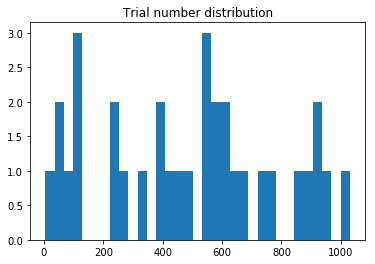

In [2]:
# Select animal to analyze
AnimalID = 'Os01'

# Find data
GeneralDirectory = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/'

ExperimentFiles = [] # to store experiment names
ExperimentData = [] # to store the dictionaries
ntrialsDistribution = [] # to visualize the distribution of the number of trials
Protocols = [] # store the protocols
counter = 0
for file in glob.glob(GeneralDirectory+AnimalID+'/Two_Alternative_Choice/Session Data/*.mat'):
    ExperimentFiles.append(file)
    
    # Read data and plot number of trials and training level
    data = load_ns.loadmat(file)
    ntrials = data['SessionData']['nTrials']
    
    # Parse the settings of the trials
    trial_raw_events = data['SessionData']['TrialSettings']
    for trial_num, trial in enumerate(trial_raw_events):
        trial_raw_events[trial_num] = load_ns._todict(trial)
    data['SessionData']['TrialSettings'] = trial_raw_events
    
    # Get info for the settings from the first trial
    try:
        protocol = trial_raw_events[0]['GUIMeta']['TrainingLevel']['String'][
            trial_raw_events[0]['GUI']['TrainingLevel'] - 1]
    except:
        protocol = 'Unknown'
        
    try:
        stimulation = trial_raw_events[0]['GUIMeta']['OptoStim']['String'][
            trial_raw_events[0]['GUI']['OptoStim'] - 1]
    except:
        stimulation = 'unknown'
        
    print('{}: {},  {} trials on protocol {}, stimulation {}'.format(counter ,ntpath.basename(file), ntrials, protocol, stimulation))
    ntrialsDistribution.append(ntrials)
    Protocols.append(protocol)
    
    # as RawEvents.Trial is a cell array of structs in MATLAB, we have to loop through the array and convert the structs to dicts
    trial_raw_events = data['SessionData']['RawEvents']['Trial']
    for trial_num, trial in enumerate(trial_raw_events):
        trial_raw_events[trial_num] = load_ns._todict(trial)
    data['SessionData']['RawEvents']['Trial'] = trial_raw_events

    # Save the data in a list
    ExperimentData.append(data)
    counter+=1

# get the date and time from the files
ExperimentTimes = custom_functions.ParseForTimes(ExperimentFiles)

    
plt.hist(ntrialsDistribution, bins=counter)
plt.title('Trial number distribution')
plt.show()

In [25]:
# select a session    
x = 27

In [26]:
# Split data into normal and opto trials
ExpNor, ExpOp = custom_functions.splitOpto(ExperimentData[x]['SessionData'])

In [35]:
# Calculate psychometric performance parameters for each
Normal_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpNor['Difficulty'], sideSelected = ExpNor['SideSelected'])
Opto_PsyPer = custom_functions.PsychPerformance(trialsDif = ExpOp['Difficulty'], sideSelected = ExpOp['SideSelected'])

In [37]:
Normal_PsyPer

{'Difficulty': array([  2.,  18.,  34.,  50.,  66.,  82.,  98.]),
 'Logit': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'Performance': array([ 82.75862069,  71.11111111,  72.09302326,  58.33333333,
         58.82352941,  50.90909091,  30.1369863 ])}

In [38]:
# predict data
predictDif = np.linspace(1, 100, 2000).reshape(-1, 1)

Normal_predictPer = 100 * Normal_PsyPer['Logit'].predict_proba(predictDif)[:,1]
Opto_predictPer = 100 * Opto_PsyPer['Logit'].predict_proba(predictDif)[:,1]

AttributeError: 'float' object has no attribute 'predict_proba'

In [21]:
# Bootstrap on fake data (generated inside the bootstrap function)
bootstrap_ntimes = 1000
np.random.seed(12233)  # fixed random seed for reproducibility

Normal_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpNor['Difficulty'],
                                                                sideSelected = ExpNor['SideSelected'],
                                                                ntimes = bootstrap_ntimes,
                                                                prediction_difficulties = predictDif)

Opto_fakePredictions = custom_functions.BootstrapPerformances(trialsDif = ExpOp['Difficulty'],
                                                                sideSelected = ExpOp['SideSelected'],
                                                                ntimes = bootstrap_ntimes,
                                                                prediction_difficulties = predictDif)

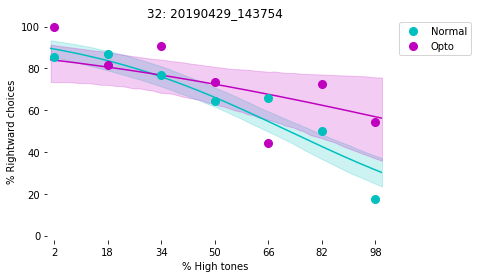

In [24]:
# plot CLEAN THIS
# calculate percentiles
Normal_percentiles = np.percentile(Normal_fakePredictions, [2.5, 97.5], axis=1).T
Opto_percentiles = np.percentile(Opto_fakePredictions, [2.5, 97.5], axis=1).T


plt.fill_between(predictDif.reshape(-1), Normal_percentiles[:,0], Normal_percentiles[:,1], alpha = 0.2, color = 'c')
plt.fill_between(predictDif.reshape(-1), Opto_percentiles[:,0], Opto_percentiles[:,1], alpha = 0.2, color = 'm')

# This plots all the fake data:
#plt.plot(predictDif, Normal_fakePredictions, 'k-', lw=0.5, alpha=0.2)

plt.plot(predictDif, Normal_predictPer, 'c-')
plt.plot(predictDif, Opto_predictPer, 'm-')

plt.plot(Normal_PsyPer['Difficulty'], Normal_PsyPer['Performance'], 'co', ms = 8, label = 'Normal')
plt.plot(Opto_PsyPer['Difficulty'], Opto_PsyPer['Performance'], 'mo', ms = 8, label = 'Opto')
#plt.plot(clf)
plt.xticks(Normal_PsyPer['Difficulty'])
plt.ylabel('% Rightward choices')
plt.xlabel('% High tones')
plt.xlim(0., 100.)
plt.ylim(-2., 102.)
plt.title(str(x) + ': ' + ExperimentTimes[x])
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

In [ ]:
# Make plots with the performance for all sessions


In [ ]:
# Modify according to above!

# pull data
SelectedExp = [24,26,32]
TrDif = np.array([y for z in [ExperimentData[x]['SessionData']['TrialHighPerc'] for x in SelectedExp] for y in z])
SideSel = np.array([y for z in [ExperimentData[x]['SessionData']['FirstPoke'] for x in SelectedExp] for y in z])
OpSt = np.array([y for z in [ExperimentData[x]['SessionData']['OptoStim'] for x in SelectedExp] for y in z])

PPN, PPO = PsychPerformance(difficulty = ExperimentData[SelectedExp[1]]['SessionData']['SettingsFile']['PercVect'],
                     trialsDif = TrDif, 
                     sideSelected = SideSel, 
                     optoStim = OpSt)

# plot
difficulty = ExperimentData[x]['SessionData']['SettingsFile']['PercVect']
plt.plot(difficulty, PPN, 'co', ms = 8, label = 'Normal')
plt.plot(difficulty, PPO, 'mo', ms = 8, label = 'Opto')
#plt.plot(clf)
plt.xticks(difficulty)
plt.ylabel('% Rightward choices')
plt.xlabel('% High tones')
plt.xlim(0., 100.)
plt.ylim(-2., 102.)
plt.title(str(SelectedExp))
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

In [ ]:
oc

In [ ]:
PPOlist

In [ ]:
sum(OpSt == 0)

In [ ]:
clf = LogisticRegression(C=1e5, solver='lbfgs')


In [ ]:
# pull data but plot each session separately BUT THIS IS NOT NORMALIZED BY THE NUMBER OF TRIALS...
# DO THIS WITH THE MODELS
SelectedExp = [24,26,32]
for x in SelectedExp:
    PPN, PPO = PsychPerformance(difficulty = ExperimentData[x]['SessionData']['SettingsFile']['PercVect'],
                     trialsDif = ExperimentData[x]['SessionData']['TrialHighPerc'], 
                     sideSelected = ExperimentData[x]['SessionData']['FirstPoke'], 
                     optoStim = ExperimentData[x]['SessionData']['OptoStim'])
    # plot
    difficulty = ExperimentData[x]['SessionData']['SettingsFile']['PercVect']
    plt.plot(difficulty, PPN, 'co', ms = 8, label = 'Normal')
    plt.plot(difficulty, PPO, 'mo', ms = 8, label = 'Opto')
#plt.plot(clf)
plt.xticks(difficulty)
plt.ylabel('% Rightward choices')
plt.xlabel('% High tones')
plt.xlim(0., 100.)
plt.ylim(-2., 102.)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(str(SelectedExp))
plt.tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()

In [ ]:
clf.fit(dif.astype(np.float64),ref.astype(np.float64))

In [ ]:
dif.astype(np.float64)

In [ ]:
ExperimentData[x]['SessionData']['OptoStim']

In [ ]:
data['SessionData'].keys()

In [ ]:
data['SessionData']['RawData'].keys()

In [ ]:
ExperimentData[23]['SessionData'].keys()

In [ ]:
ExperimentData[24]['SessionData']['SettingsFile']['PercVect']

In [ ]:
len(data['SessionData']['RawEvents']['Trial'])